In [6]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Using device: {device}')

device = "cuda:6"

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 9, 6, 7, 8, 7, 7, 2])


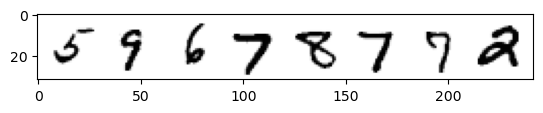

In [7]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

# 创建以类别为条件的UNet

In [8]:
class ClassConditionUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        self.class_emb_layer = nn.Embedding(num_classes, class_emb_size)

        self.model = UNet2DModel(
            sample_size=28,           # the target image resolution
            in_channels=1 + class_emb_size, # Additional input channels for class cond.
            out_channels=1,           # the number of output channels
            layers_per_block=2,       # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64), 
            down_block_types=( 
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D", 
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )

    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        class_cond = self.class_emb_layer(class_labels)
        # class_cond(batch_size, emb_size)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
        
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)
        # Feed this to the unet alongside the timestep and return the prediction
        
        return self.model(net_input, t).sample # (bs, 1, 28, 28)


# 训练

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

model = ClassConditionUnet(num_classes=10, class_emb_size=4).to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

losses = []
# 30以上会有比较好的效果
epochs = 200

for epoch in range(epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs}")

    for step, (imag, label) in enumerate(loop):
        imag = imag.to(device) * 2 - 1
        label = label.to(device)
        noise = torch.randn_like(imag).to(device)
        timesteps = torch.randint(0,999,(imag.shape[0],)).to(device)
        noisy_image = noise_scheduler.add_noise(imag, noise, timesteps)

        pred_noise = model(noisy_image, timesteps, label)

        loss = loss_fn(pred_noise, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        
print("Train Finish!")
plt.plot(losses)

# 测试

0it [00:00, ?it/s]

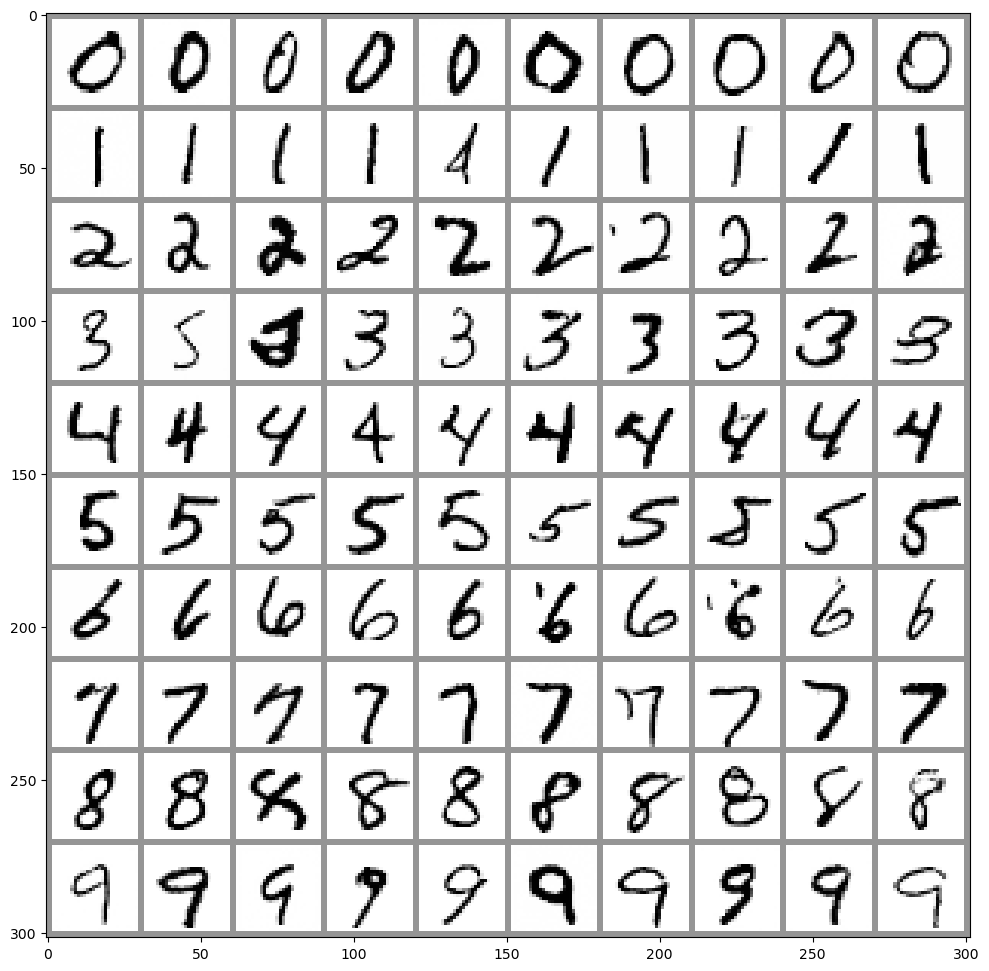

In [12]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=10)[0], cmap='Greys')

In [11]:
torch.save(model.state_dict(), f"U3_Condition_Diffusion_epoch_200.pth")